In [ ]:
!pip install transformers
!pip install scikit-learn
!pip install sentence_transformers
!pip install neptune

# Building Aegis

In [14]:
import torch
import gc

def reset_cuda_memory():
    gc.collect()
    torch.cuda.empty_cache()

In [15]:
reset_cuda_memory()

In [16]:
import random

_fn = "final"
LENGTH = 512
BATCH_SIZE = 16
STEP_SIZE=1

RANDOM_SEED = 42

EMBEDDING_SIZE = 768
HIDDEN_SIZE = 512
CNN_FILTERS=128

BERT_MODEL_ID = "microsoft/codebert-base"

# you must use cuda to run this code. if this returns false, you can not proceed.
USE_CUDA = torch.cuda.is_available()

if USE_CUDA:
    print("You are using cuda. Good!")
else:
    print('You are NOT using cuda! Some problems may occur.')

torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

You are using cuda. Good!


In [17]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as opt


from transformers import AutoModel, AutoTokenizer
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from sklearn.metrics import f1_score,accuracy_score
from tqdm import tqdm

# Preparing Dataset

In [201]:
import pandas as pd

final_df = pd.read_csv('data/VulPySec_Dataset_withDependencies')
final_df

,code,label,unc_code,unc_num_lines
0,import numpy as np\n\ndef _get_random_inputs_a...,SAFE,import numpy as np\ndef _get_random_inputs_and...,17
1,import sqlite3\n\ndef format_output(database):...,SAFE,import sqlite3\ndef format_output(database):\n...,19
2,from typing import List\nfrom telegram import ...,SAFE,from typing import List\nfrom telegram import ...,12
3,import sqlalchemy\nfrom flask import Flask\nfr...,SAFE,import sqlalchemy\nfrom flask import Flask\nfr...,16
4,"{\n 'name': 'John',\n 'age': 30,\n 'c...",SAFE,"{\n 'name': 'John',\n 'age': 30,\n 'c...",9
...,...,...,...,...
152583,"self.proxy = {\n ""http"": ""http://proxy-ip:p...",SAFE,"self.proxy = {\n ""http"": ""http://proxy-ip:p...",4
152584,import requests\nfrom Crypto.Cipher import AES...,CWE-327,import requests\nfrom Crypto.Cipher import AES...,14
152585,proxies = {\n 'http': 'http://proxy_user:pr...,SAFE,proxies = {\n 'http': 'http://proxy_user:pr...,4
152586,import os\nimport requests\nimport requests_to...,CWE-20,import os\nimport requests\nimport requests_to...,16


In [19]:
# Split the DataFrame into train and test sets
train_df, test_df = train_test_split(final_df, test_size=0.2, random_state=RANDOM_SEED, shuffle=True, stratify=final_df["label"])

In [20]:
# Tokenize the input data
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_ID)

def tokenize_dataset(df: pd.DataFrame, tokenizer):
    seq_in = list(df.unc_code)
    target = list(df.label)
    tok_in = tokenizer.batch_encode_plus(seq_in, add_special_tokens=True, max_length=LENGTH, 
                          return_attention_mask=True , padding='max_length', 
                          truncation=True, return_tensors='pt')
    return seq_in, tok_in, target

In [21]:
seq_in, tok_in, target = tokenize_dataset(train_df, tokenizer)
test_seq_in, test_tok_in, test_target = tokenize_dataset(test_df, tokenizer)

In [22]:
# this function turns class text to id
def prepare_intent(target, to_ix):
    idxs = to_ix[target] if target in to_ix.keys() else to_ix["UNKNOWN"]
    return idxs

#initialize label to index
target2index={'SAFE':0}
for i in set(target):
    if i not in target2index.keys():
        target2index[i] = len(target2index)
index2target = {v:k for k,v in target2index.items()}
num_labels = len(index2target)

In [23]:
index2target, num_labels, target2index

({0: 'SAFE',
  1: 'CWE-78',
  2: 'CWE-605',
  3: 'CWE-502',
  4: 'CWE-377',
  5: 'CWE-20',
  6: 'CWE-259',
  7: 'CWE-330',
  8: 'CWE-703',
  9: 'CWE-319',
  10: 'CWE-400',
  11: 'CWE-89',
  12: 'CWE-327',
  13: 'CWE-22'},
 14,
 {'SAFE': 0,
  'CWE-78': 1,
  'CWE-605': 2,
  'CWE-502': 3,
  'CWE-377': 4,
  'CWE-20': 5,
  'CWE-259': 6,
  'CWE-330': 7,
  'CWE-703': 8,
  'CWE-319': 9,
  'CWE-400': 10,
  'CWE-89': 11,
  'CWE-327': 12,
  'CWE-22': 13})

In [24]:
class VulPySecDataset(Dataset):
    def __init__(self, seq_in, tok_in, target):
        self.seq_in = seq_in #.cuda()
        self.input_ids = tok_in.input_ids.cuda()
        self.attention_mask = tok_in.attention_mask.cuda()
        self.tgt = torch.LongTensor([target2index[temp] for temp in target]).cuda()
    
    def __len__(self):
        return len(self.tgt)
    
    def __getitem__(self, idx):
        sample = self.seq_in[idx], self.input_ids[idx], self.attention_mask[idx], self.tgt[idx]
        return sample

In [25]:
train_data = VulPySecDataset(seq_in, tok_in, target)
test_data = VulPySecDataset(test_seq_in, test_tok_in, test_target)

train_data_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=BATCH_SIZE*2, shuffle=False)

# Modeling

In [26]:
class BertLayer(nn.Module):
    def __init__(self):
        super(BertLayer, self).__init__()
        self.bert_model = AutoModel.from_pretrained(BERT_MODEL_ID)
    
    def forward(self, input_ids=None, attention_mask=None):
        bert_encodings = self.bert_model(input_ids, attention_mask)
        bert_last_hidden = bert_encodings['last_hidden_state']
        # bert_pooler_output = bert_encodings['pooler_output']
        return bert_last_hidden, None

In [27]:
class CNNEncoder(nn.Module):
    def __init__(self,):
        super(CNNEncoder, self).__init__()
        self.embedding_size = EMBEDDING_SIZE
        self.filter_number = CNN_FILTERS
        self.activation = nn.ReLU()

        
        self.conv1 = nn.Conv1d(in_channels=self.embedding_size, out_channels=self.filter_number, kernel_size=(2,),
                              padding="same", padding_mode="zeros")
        self.conv2 = nn.Conv1d(in_channels=self.embedding_size, out_channels=self.filter_number, kernel_size=(3,),
                              padding="same", padding_mode="zeros")
        self.conv3 = nn.Conv1d(in_channels=self.embedding_size, out_channels=self.filter_number, kernel_size=(5,),
                              padding="same", padding_mode="zeros")
        self.conv4 = nn.Conv1d(in_channels=self.embedding_size, out_channels=self.filter_number, kernel_size=(1,),
                              padding="same", padding_mode="zeros")
        
    def forward(self, bert_last_hidden):
        trans_embedded = torch.transpose(bert_last_hidden, dim0=1, dim1=2)
        
        convolve1 = self.activation(self.conv1(trans_embedded))
        convolve2 = self.activation(self.conv2(trans_embedded))
        convolve3 = self.activation(self.conv3(trans_embedded))
        convolve4 = self.activation(self.conv4(trans_embedded))
        
        convolve1 = torch.transpose(convolve1, dim0=1, dim1=2)
        convolve2 = torch.transpose(convolve2, dim0=1, dim1=2)
        convolve3 = torch.transpose(convolve3, dim0=1, dim1=2)
        convolve4 = torch.transpose(convolve4, dim0=1, dim1=2)
        
        output = torch.cat((convolve4, convolve1, convolve2, convolve3), dim=2)
        return output

In [28]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        postion = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(postion * div_term)
        pe[:, 0, 1::2] = torch.cos(postion * div_term)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)     

In [29]:
class Middle(nn.Module):
    def __init__(self):
        super(Middle, self).__init__()
        self.activation = nn.ReLU()
        self.pos_encoder = PositionalEncoding(HIDDEN_SIZE, dropout=0.1)
        encoder_layers = nn.TransformerEncoderLayer(HIDDEN_SIZE, nhead=2,batch_first=True, dim_feedforward=2048 ,activation="relu", dropout=0.1)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=2, enable_nested_tensor=False)
    
    def forward(self, encodings, input_mask):
        src = encodings * math.sqrt(HIDDEN_SIZE)
        src = self.pos_encoder(src)
        out = self.transformer_encoder(src, src_key_padding_mask=input_mask)
        return out

In [30]:
class Decoder(nn.Module):
    def __init__(self, num_labels=14, dropout_p=0.5):
        super(Decoder, self).__init__()
        self.num_labels = num_labels
        self.self_attention = nn.MultiheadAttention(embed_dim=HIDDEN_SIZE
                                                    ,num_heads=8,dropout=0.1
                                                    ,batch_first=True)
        self.dropout = nn.Dropout(dropout_p)
        self.layer_norm = nn.LayerNorm(HIDDEN_SIZE)
        self.score = nn.Linear(HIDDEN_SIZE, self.num_labels)

    
    def forward(self, encodings, input_mask):
        encodings2 = encodings.clone()
        context, attention_weights = self.self_attention(encodings2,encodings2,encodings2,
                                     key_padding_mask=input_mask, need_weights=True)
        encodings2 = self.layer_norm(self.dropout(context)) + encodings2
        sum_mask = (~input_mask).sum(1).unsqueeze(1)
        sum_encoder = ((((encodings2)))*((~input_mask).unsqueeze(2))).sum(1)
        score = self.score(self.dropout(sum_encoder/sum_mask))
        
        return score, attention_weights

In [31]:
num_labels

14

In [32]:
class AEGIS(nn.Module):
    def __init__(self, num_labels=num_labels, dropout_p=0.5):
        super(AEGIS, self).__init__()
        self.bert_layer = BertLayer()
        self.cnn_encoder = CNNEncoder()
        self.middle = Middle()
        self.decoder = Decoder(num_labels=num_labels, dropout_p=dropout_p)

    def forward(self, input_ids, attention_mask):
        bert_hidden, _ = self.bert_layer(input_ids, attention_mask)
        encoder_output = self.cnn_encoder(bert_hidden)
        output = self.middle(encoder_output, attention_mask==0)
        score, attention_weights = self.decoder(output, attention_mask==0)
        return score, attention_weights

# Training

In [34]:
aegis = AEGIS(num_labels=num_labels)
if USE_CUDA:
    aegis.cuda()

loss_function = nn.CrossEntropyLoss()

optim = opt.AdamW(aegis.parameters(),lr=2e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optim, 2500, gamma=0.96)

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [ ]:

max_acc = 0.

for step in tqdm(range(STEP_SIZE)):        
    losses = []
    accuracy = []

    ### TRAIN
    aegis.train()
    
    for i, (seq_in, input_ids, attention_mask, tgt) in enumerate(train_data_loader):
        batch_size = tgt.size(0)
        
        aegis.zero_grad()

        score, _ = aegis(input_ids, attention_mask)
        
        loss = loss_function(score, tgt)
        
        losses.append(loss.data.cpu().numpy() if USE_CUDA else loss.data.numpy()[0])
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(aegis.parameters(), 0.5)
        
        optim.step()
        
        accuracy.append(accuracy_score(tgt.detach().cpu(), torch.argmax(score, dim=1).detach().cpu()))
        
        print("Step", step, "batches", i, ":")
        print("Train-")
        l = loss.data.cpu().numpy() if USE_CUDA else loss.data.numpy()[0]
        a = accuracy_score(tgt.detach().cpu(), torch.argmax(score, dim=1).detach().cpu())
        print(f"loss_per_batch:{round(float(l),4)}")
        print(f"accuracy_per_batch:{round(float(a),3)}")
        
        scheduler.step()

    
    print("Step", step, ":")
    print("Train-")
    print(f"loss:{round(float(np.mean(losses)),4)}")
    print(f"accuracy:{round(float(np.mean(accuracy)),3)}")
    
    
    losses = []
    accuracy = []

    #### TEST        
    aegis.eval()
    with torch.no_grad():
        for i, (seq_in, input_ids, attention_mask, tgt) in enumerate(test_data_loader):
            batch_size = tgt.size(0)
            
            score, _ = aegis(input_ids, attention_mask)

            loss = loss_function(score, tgt)
            
            losses.append(loss.data.cpu().numpy() if USE_CUDA else loss.data.numpy())
            accuracy.append(accuracy_score(tgt.detach().cpu(), torch.argmax(score, dim=1).detach().cpu()))
    print("Test-")
    print(f"loss:{round(float(np.mean(losses)),4)}")
    print(f"accuracy:{round(float(np.mean(accuracy)),4)}")
    print("--------------")
    
    max_acc = max_acc if round(float(np.mean(accuracy)),4) <= max_acc else round(float(np.mean(accuracy)),4)
    if max_acc <= round(float(np.mean(accuracy)),4):
        torch.save(aegis, f"models/aegis-{_fn}.pkl")
        
    
print(f"max single acc: {max_acc}")

  0%|          | 0/1 [00:00<?, ?it/s]/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /opt/conda/conda-bld/pytorch_1696595231861/work/aten/src/ATen/native/Convolution.cpp:1008.)
  return F.conv1d(input, weight, bias, self.stride,


Step 0 batches 0 :
Train-
loss_per_batch:2.963
accuracy_per_batch:0.062
Step 0 batches 1 :
Train-
loss_per_batch:2.828
accuracy_per_batch:0.062
Step 0 batches 2 :
Train-
loss_per_batch:2.4193
accuracy_per_batch:0.188
Step 0 batches 3 :
Train-
loss_per_batch:2.8074
accuracy_per_batch:0.188
Step 0 batches 4 :
Train-
loss_per_batch:2.7526
accuracy_per_batch:0.125
Step 0 batches 5 :
Train-
loss_per_batch:3.0384
accuracy_per_batch:0.125
Step 0 batches 6 :
Train-
loss_per_batch:2.8369
accuracy_per_batch:0.125
Step 0 batches 7 :
Train-
loss_per_batch:2.9942
accuracy_per_batch:0.062
Step 0 batches 8 :
Train-
loss_per_batch:2.6578
accuracy_per_batch:0.312
Step 0 batches 9 :
Train-
loss_per_batch:2.8499
accuracy_per_batch:0.188
Step 0 batches 10 :
Train-
loss_per_batch:2.5207
accuracy_per_batch:0.312
Step 0 batches 11 :
Train-
loss_per_batch:3.1411
accuracy_per_batch:0.0
Step 0 batches 12 :
Train-
loss_per_batch:2.6749
accuracy_per_batch:0.125
Step 0 batches 13 :
Train-
loss_per_batch:2.6953
acc

100%|██████████| 1/1 [1:06:08<00:00, 3968.68s/it]

max single acc: 0.9843
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.


[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/a.mechri/AEGIS/e/AEG-19/metadata


# Load the trained model

In [37]:
aegis2 = AEGIS(num_labels=len(target2index))
aegis2.load_state_dict(torch.load(f"models/aegis-{_fn}.pkl").state_dict())
if USE_CUDA:
    aegis2.cuda()

In [38]:
 #### TEST
y_pred = []
y_true = []

aegis2.eval()
with torch.no_grad():
    for i, (seq_in, input_ids, attention_mask, tgt) in enumerate(test_data_loader):
        batch_size = tgt.size(0)

        score, _ = aegis2(input_ids, attention_mask)
        y_pred.extend(torch.argmax(score, dim=1).detach().cpu().numpy())
        y_true.extend(tgt.detach().cpu().numpy())

        loss = loss_function(score, tgt)

        losses.append(loss.data.cpu().numpy() if USE_CUDA else loss.data.numpy())
        accuracy.append(accuracy_score(tgt.detach().cpu(), torch.argmax(score, dim=1).detach().cpu()))
print("Test-")
print(f"loss:{round(float(np.mean(losses)),4)}")
print(f"accuracy:{round(float(np.mean(accuracy)),4)}")
print("--------------")



print(f"max single acc: {max_acc}")

Test-
loss:0.1158
accuracy:0.9843
--------------
max single acc: 0.9843


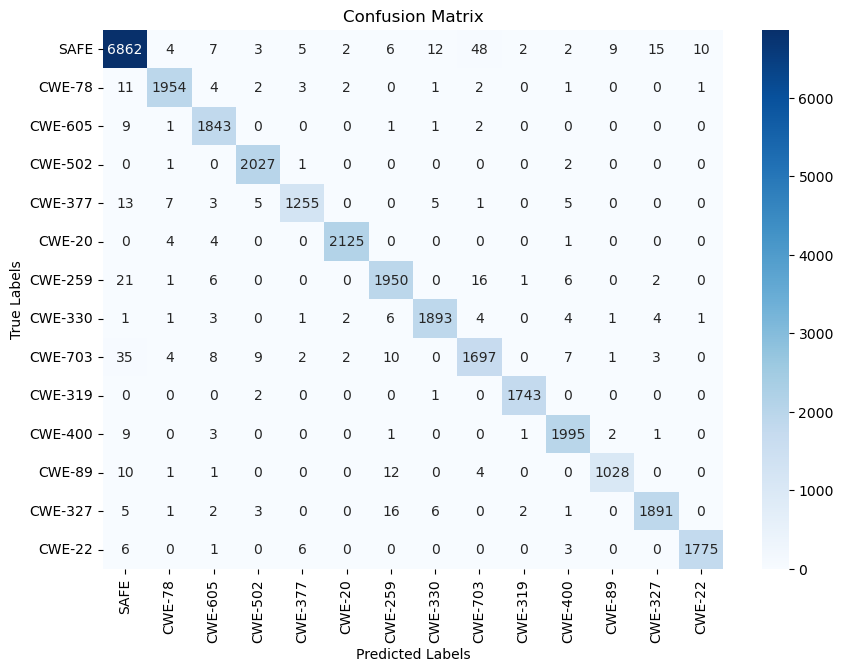

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report



# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[index2target[i] for i in range(len(index2target))], yticklabels=[index2target[i] for i in range(len(index2target))])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [40]:
# Print the classification report
print(classification_report(y_true, y_pred, target_names=list(index2target.values())))

              precision    recall  f1-score   support

        SAFE       0.98      0.98      0.98      6987
      CWE-78       0.99      0.99      0.99      1981
     CWE-605       0.98      0.99      0.99      1857
     CWE-502       0.99      1.00      0.99      2031
     CWE-377       0.99      0.97      0.98      1294
      CWE-20       1.00      1.00      1.00      2134
     CWE-259       0.97      0.97      0.97      2003
     CWE-330       0.99      0.99      0.99      1921
     CWE-703       0.96      0.95      0.96      1778
     CWE-319       1.00      1.00      1.00      1746
     CWE-400       0.98      0.99      0.99      2012
      CWE-89       0.99      0.97      0.98      1056
     CWE-327       0.99      0.98      0.98      1927
      CWE-22       0.99      0.99      0.99      1791

    accuracy                           0.98     30518
   macro avg       0.98      0.98      0.98     30518
weighted avg       0.98      0.98      0.98     30518



Example of model prediction on test dataset


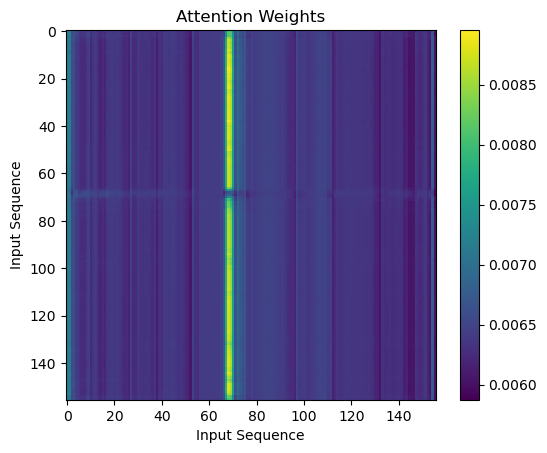

Code Source:
 import random
def generate_dungeon():
    dungeon = []
    for _ in range(10):
        row = []
        for _ in range(10):
            if random.random() < 0.4:
                row.append('#')
            else:
                row.append('.')
        dungeon.append(row)
    return dungeon 
----------------
Ground Truth       :  CWE-330
Prediction  :  CWE-330


In [75]:
print("Example of model prediction on test dataset")

with torch.no_grad():
    index = random.choice(range(len(test_data)))
    seq_in, input_ids, attention_mask, tgt = test_data[index]
    input_ids =  input_ids.unsqueeze(0).cuda()
    attention_mask =  attention_mask.unsqueeze(0).cuda()
    
    
    score, attention_weights = aegis2(input_ids, attention_mask)

    mask = attention_mask.cpu().squeeze().numpy()

    # Create a masked attention weights tensor
    masked_attention_weights = attention_weights.cpu().squeeze().numpy()
    masked_attention_weights = masked_attention_weights[:, mask.astype(bool)]
    masked_attention_weights = masked_attention_weights[mask.astype(bool), :]

    # plt.imshow(masked_attention_weights, cmap='hot', interpolation='nearest')
    plt.imshow(masked_attention_weights, cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.xlabel('Input Sequence')
    plt.ylabel('Input Sequence')
    plt.title('Attention Weights')
    plt.show()
    
    v,i = torch.max(score,1)
    print("Code Source:\n",seq_in,"\n----------------")
    print("Ground Truth       : ", index2target[int(tgt.cpu())])
    print("Prediction  : ",index2target[i.data.tolist()[0]])

Example of model prediction on test dataset


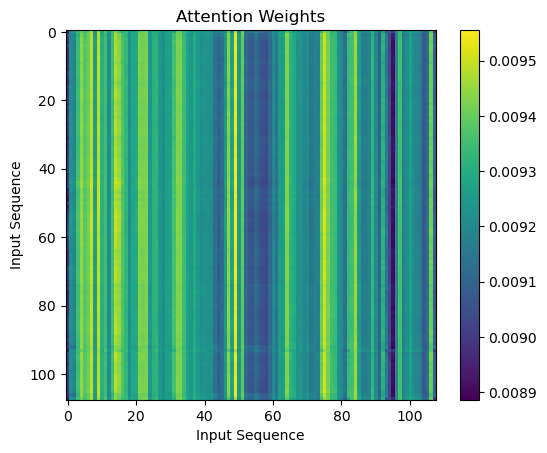

Code Source:
 import sqlite3
def get_budget(user_id, database):
    conn = database.connect()
    cursor = conn.cursor()
    query = f'SELECT budget FROM users WHERE user_id={user_id}'
    cursor.execute(query)
    budget = cursor.fetchone()[0]
    cursor.close()
    conn.close()
    return budget 
----------------
Ground Truth       :  CWE-89
Prediction  :  CWE-89


In [80]:
print("Example of model prediction on test dataset")

with torch.no_grad():
    index = random.choice(range(len(test_data)))
    seq_in, input_ids, attention_mask, tgt = test_data[index]
    input_ids =  input_ids.unsqueeze(0).cuda()
    attention_mask =  attention_mask.unsqueeze(0).cuda()
    
    
    score, attention_weights = aegis2(input_ids, attention_mask)

    mask = attention_mask.cpu().squeeze().numpy()

    # Create a masked attention weights tensor
    masked_attention_weights = attention_weights.cpu().squeeze().numpy()
    masked_attention_weights = masked_attention_weights[:, mask.astype(bool)]
    masked_attention_weights = masked_attention_weights[mask.astype(bool), :]

    # plt.imshow(masked_attention_weights, cmap='hot', interpolation='nearest')
    plt.imshow(masked_attention_weights, cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.xlabel('Input Sequence')
    plt.ylabel('Input Sequence')
    plt.title('Attention Weights')
    plt.show()
    
    v,i = torch.max(score,1)
    print("Code Source:\n",seq_in,"\n----------------")
    print("Ground Truth       : ", index2target[int(tgt.cpu())])
    print("Prediction  : ",index2target[i.data.tolist()[0]])

Example of model prediction on test dataset


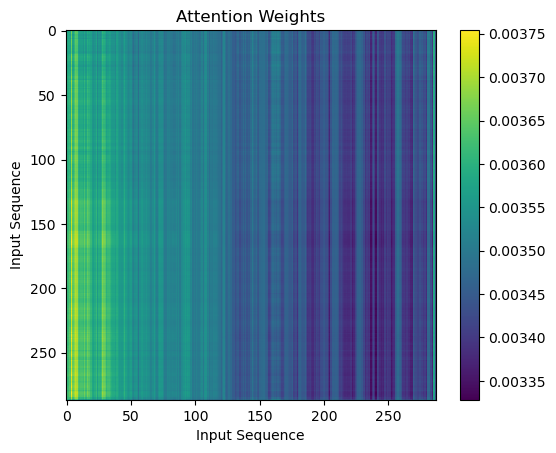

Code Source:
 import socket
import threading
def handle_client(client_socket, addr):
    print(f'[*] Accepted connection from: {addr[0]}:{addr[1]}')
    request = client_socket.recv(1024).decode()
    print('[*] Received: {request}')
    client_socket.send("HTTP/1.1 200 OK\r\n\r\nHello, world!").encode()
    client_socket.close()
def main():
    server = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    server.bind(('0.0.0.0', 80))
    server.listen(5)
    print('[*] Listening on all interfaces at port 80')
    while True:
        client_socket, addr = server.accept()
        client_thread = threading.Thread(target=handle_client, args=(client_socket, addr))
        client_thread.start()
if __name__ == '__main__':
    main() 
----------------
Ground Truth       :  CWE-605
Prediction  :  CWE-605


In [198]:
print("Example of model prediction on test dataset")

with torch.no_grad():
    index = random.choice(range(len(test_data)))
    seq_in, input_ids, attention_mask, tgt = test_data[index]
    input_ids =  input_ids.unsqueeze(0).cuda()
    attention_mask =  attention_mask.unsqueeze(0).cuda()
    
    
    score, attention_weights = aegis2(input_ids, attention_mask)

    mask = attention_mask.cpu().squeeze().numpy()

    # Create a masked attention weights tensor
    masked_attention_weights = attention_weights.cpu().squeeze().numpy()
    masked_attention_weights = masked_attention_weights[:, mask.astype(bool)]
    masked_attention_weights = masked_attention_weights[mask.astype(bool), :]

    # plt.imshow(masked_attention_weights, cmap='hot', interpolation='nearest')
    plt.imshow(masked_attention_weights, cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.xlabel('Input Sequence')
    plt.ylabel('Input Sequence')
    plt.title('Attention Weights')
    plt.show()
    
    v,i = torch.max(score,1)
    print("Code Source:\n",seq_in,"\n----------------")
    print("Ground Truth       : ", index2target[int(tgt.cpu())])
    print("Prediction  : ",index2target[i.data.tolist()[0]])